In [1]:
# Importing required packages 
from qiskit import IBMQ, QuantumCircuit, Aer, execute
from qiskit.quantum_info import Operator, Statevector, state_fidelity
from qiskit.visualization import plot_state_qsphere, plot_histogram, plot_state_city
from qiskit.aqua.components.optimizers import COBYLA
from qiskit.providers.aer.noise import NoiseModel
from qiskit.aqua.algorithms import VQE
import numpy as np
import random, math
from scipy import optimize as opt
import matplotlib.pyplot as plt
from IPython.display import Image
import mitiq

provider = IBMQ.load_account()


C:\Users\javie\anaconda3\envs\qiskit_env\lib\site-packages\qiskit\providers\ibmq\ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


# Introduction 

Quantum computers provide a natural platform to perform simulations for the evolution of systems
Proposals of simulations of quantum field theories and experimental implementation (Zoller etc.) 
Klco et al. reducing the physical space and studying the discretized Schwinger model, proposal to study the noise restrictions they faced with the help of the mitiq package

## VQE of the ground state energy 

Through the use of physical symmetries within the system it is possible to restrict the matrix to the form 

\begin{equation}
H_{k=0,+}^{\lambda^2 = 3} =
\begin{pmatrix}
-2\mu & 2x & 0 & 0\\
2x & 1 & \sqrt{2}x & 0\\
0 & \sqrt{2}x & 2 + 2\mu & \sqrt{2}x \\
0 & 0 & \sqrt{2}x & 3 
\end{pmatrix}
\end{equation}

This 4x4 matrix can then be expressed in term of the polywords

\begin{equation}
\cal{O}_{i,j} = \frac{1}{4}\sigma_{i} \otimes \sigma_{j} 
\end{equation}
with $i,j = 0,1,2,3$ representing the Pauli matrices. Such that the hamiltonian is written as
\begin{equation}
H = \sum_{i,j} c_{i,j}\cal{O}_{i,j}
\end{equation} 
with each coefficient calculated as inner product of the matrices with the Hamiltonian (equivalent to finding the coefficients of real vector through the application of dot products) 

\begin{equation}
c_{i,j} = Tr( \cal{O}^{\dagger}H) = Tr( \cal{O}H) 
\end{equation}





Supposing we already have the decomposition then we can then express the expectation value of the energy of the hamiltonian as 

\begin{equation} 
    \left< H \right>_{\theta} = \sum_{i}c_{i} \big< \psi(\vec{\theta}) \big| \cal{O}_{i} \big| \psi(\vec{\theta})\big>
\end{equation}

where the initial state $\big| \psi(\vec{\theta})\big> $ is determined to an specific anzats created by the circuit in E10  

To properly implement in qiskit we use the RX,RY and RZ defined as 
 
\begin{align*} 
RX(\theta) &= e^{-i\theta\frac{\sigma_{X}}{2}} \\ 
RY(\theta) &= e^{-i\theta\frac{\sigma_{Y}}{2}} \\
RZ(\theta) &= e^{-i\theta\frac{\sigma_{Z}}{2}} \\ 
\end{align*}

The created circuit is such that 

\begin{equation}
    \big| \psi(\vec{\theta})\big> = U( \vec{\theta} ) \big| \vec{0} \big>
\end{equation}

In order to find the expected value it is usefu to consider a general qubit of the form 

\begin{equation}
    \big| \psi \big> = p_{00}\big| 00 \big> + p_{01}\big| 01 \big> + p_{10}\big| 10 \big> + p_{11}\big| 11 \big> 
\end{equation}

and consider the result of the expetation value of this state with a $\sigma_{Z} \otimes \sigma_{Z}$

\begin{split}
   \big< \psi \big| \sigma_{Z} \otimes \sigma_{Z} \big| \psi \big> &= \big< \psi \big| \sigma_{Z} \otimes \sigma_{Z} \Big(  p_{00}\big| 00 \big> + p_{01}\big| 01 \big> + p_{10}\big| 10 \big> + p_{11}\big| 11 \big> \Big) \\
   &=  \big< \psi \big| \Big(  p_{00}\big| 00 \big> - p_{01}\big| 01 \big> - p_{10}\big| 10 \big> + p_{11}\big| 11 \big>   \Big) \\
   &=  |p_{00}|^2 + |p_{11}|^2 - \big( |p_{10}|^2 + |p_{01}|^2  \big)
\end{split}

so in order to measure the expectation value from the results of an experiment, we just need to sum the counts with the formula above. For the case when the other pauli matrices appear there only needs to be a change in the basis of the measurements as 

\begin{align*}
\sigma_{X} &= (H)^{\dagger} \sigma_{Z} H \\
\sigma_{Y} &= (HS^{\dagger})^{\dagger} \sigma_{Z} HS^{\dagger}
\end{align*}




In [14]:
#Function to prepare the hamiltonian alognside the traceless one 
def Hamiltonian(mu,x):
    H = np.array([[-2*mu, 2*x, 0, 0],\
                  [2*x, 1, np.sqrt(2)*x, 0],\
                  [0, np.sqrt(2)*x, 2+2*mu, np.sqrt(2)*x],\
                  [0, 0, np.sqrt(2)*x, 3]])
    HT = H - (3/2)*np.eye(4)
    
    return H,HT



#Values used in the paper minimization
[H,HT] = Hamiltonian(0.1,0.6)


#Find the eigenvalues of the matrix to see if they 
#are the same 
eigenH,_ = np.linalg.eig(H);
print(eigenH)

[-1.01163997  1.10260078  2.26804891  3.64099028]


To archive our task we will develop independent functions that will calculate the pauli matrix decomposition of the hamiltonian, in order to succesfully calculate the expectation value. 
Then we will utilize the circuit anzat from the paper and implement with three free parameters to optimize for.
A function that will modify such circuit to find the right measurement reference
And a function that will run the cirucit and extract the expectation values for different pauli coefficients 


In [69]:
def Decomposition_H(H):

#ADD DESCRIPTION OF INPUT AND OUTPUT
    
    #Definition of the pauli matrices 
    sigma_0 = np.eye(2)
    sigma_X = np.array([[0,1],[1,0]])
    sigma_Y = np.array([[0,-1j],[1j,0]])
    sigma_Z = np.array([[1,0],[0,-1]])
    Pauli = [sigma_0,sigma_X,sigma_Y,sigma_Z]
    Pauli_name = ['I','X','Y','Z']
    
    #Creaiton of the pauli_words
    ii = 0 
    Poly = []
    Poly_name = []
    for i in Pauli:
        jj = 0
        for j in Pauli:
            Poly.append(np.kron(i,j))
            Poly_name.append(Pauli_name[ii] + Pauli_name[jj])
            jj += 1
        ii += 1

    
    #Doing the partial trace for the coefficinets 
    c = {}
    for i in range(len(Poly)):
        c[Poly_name[i]] = np.real(np.trace(np.matmul(Poly[i],H))/4)
        
    return c



def State_Preparation(theta,r = 1):

#ADD DESCRIPTION OF INPUT AND OUTPUT

    qc = QuantumCircuit(2,2)
    
    qc.ry(theta[1],0)
    qc.ry(theta[0],1)
    for i in range(2*r-1):
        qc.cnot(0,1)
    
    qc.ry(theta[0],1)
    for i in range(2*r-1):
        qc.cnot(0,1)
        
    qc.ry(theta[2],1)
    
    
    return qc

def Circuit_Measurement(qc,key):
    
    qc_state = qc.copy() #Save original state of quantum circuit

    #Add pauli gates for different expectation values
    for q in range(2): #Lopp over two qubits
        if key[q] == 'I' or key[q] == 'Z':
            pass
        elif key[q] == 'X':
            qc_state.h(q)
        elif key[q] == 'Y':
            qc_state.sdg(q)
            qc_state.h(q)
                    
    #Add measurement to the circut
    qc_state.measure([0,1], [0,1])
    
    return qc_state



def Expectation_Measurement(qc,key,shots=8192,backend = 'qasm_simulator', noise = False):

    #Noise parameter should include name of the machine used to model noise 
    #if you want to run on the machine, noise should be set to false and backend with the name of the machine selected
       
    if noise == False:
        #Run the circuit 

        job = execute(
        experiments=qc,
        #backend=provider.get_backend("machine name") to run on hardware
        backend=Aer.get_backend(backend),
        optimization_level=0, shots=shots
        )

    else:
        #Run the circuit
        #Note the order of the input tuple is coupling, basis and then noise
        backend_noise = provider.get_backend(noise)
        noise_model = NoiseModel.from_backend(backend_noise)
        coupling_map = backend_noise.configuration().coupling_map
        basis_gates = noise_model.basis_gates

        job = execute(experiments = qc, backend = Aer.get_backend(backend),
         coupling_map= coupling_map,
         basis_gates=basis_gates,
         noise_model=noise_model,
         optimization_level=0, 
         shots=shots
         )


    #Extract the results counts 
    counts_original = job.result().get_counts()
    counts = {}
    
    for key_count in counts_original.keys():
        counts[key_count.replace(" ","")] = counts_original[key_count]
    
    #Insert missing counts in case they're zero
    if '00' not in counts:
        counts['00'] = 0
    if '01' not in counts:
        counts['01'] = 0
    if '10' not in counts:
        counts['10'] = 0
    if '11' not in counts:
        counts['11'] = 0 


    if key[0] == 'I':
        if key[1] == 'I':            
            # Case + + + +
            exp_counts = counts['00'] + counts['01'] + counts['10'] + counts['11']
            exp = exp_counts/shots

        else: 
            # Case + - + - 
            exp_counts = counts['00'] + counts['01'] - counts['10'] - counts['11']
            exp = exp_counts/shots
    else:
        if key[1] == 'I':
            #Case + + - -
            exp_counts = counts['00'] - counts['01'] + counts['10'] - counts['11']
            exp = exp_counts/shots

        else:
            #Case + - - +
            exp_counts = counts['00'] - counts['01'] - counts['10'] + counts['11']
            exp = exp_counts/shots

    #print(exp)
    return exp


In [70]:
#Example dictionary result
coef = Decomposition_H(H)
print(coef)

#Example circuit for state preparation 
qc = State_Preparation([7.27033532, 3.66176275, 1.85667239],r=1)
print(qc)

#Example for circuit to measure 'IX' expectation value
qc_IX = Circuit_Measurement(qc,'ZI')
print(qc_IX)

#Example of expectation value run for quantum circuit IX with parameters in qc
Expectation_IX = Expectation_Measurement(qc_IX,'ZI',noise = False )
print(Expectation_IX)

{'II': 1.5, 'IX': 1.0242640687119284, 'IY': 0.0, 'IZ': -0.49999999999999994, 'XI': 0.0, 'XX': 0.4242640687119285, 'XY': 0.0, 'XZ': 0.0, 'YI': 0.0, 'YX': 0.0, 'YY': 0.4242640687119285, 'YZ': 0.0, 'ZI': -1.1, 'ZX': 0.17573593128807144, 'ZY': 0.0, 'ZZ': -0.10000000000000009}
     ┌────────────┐                                      
q_0: ┤ RY(3.6618) ├──■──────────────────■────────────────
     ├────────────┤┌─┴─┐┌────────────┐┌─┴─┐┌────────────┐
q_1: ┤ RY(7.2703) ├┤ X ├┤ RY(7.2703) ├┤ X ├┤ RY(1.8567) ├
     └────────────┘└───┘└────────────┘└───┘└────────────┘
c: 2/════════════════════════════════════════════════════
                                                         
     ┌────────────┐                                      ┌─┐   
q_0: ┤ RY(3.6618) ├──■──────────────────■────────────────┤M├───
     ├────────────┤┌─┴─┐┌────────────┐┌─┴─┐┌────────────┐└╥┘┌─┐
q_1: ┤ RY(7.2703) ├┤ X ├┤ RY(7.2703) ├┤ X ├┤ RY(1.8567) ├─╫─┤M├
     └────────────┘└───┘└────────────┘└───┘└────────────┘ ║ └╥┘
c

We are using the qasm_simulator because it mimicks the behaviour of an actual device (https://qiskit.org/documentation/tutorials/simulators/1_aer_provider.html)

Give that we want to use mitiq to find 

Now we are in a position to construct the function to construct the function that gives the result of the expectation value 

In [75]:
def Expectation_Hamiltonian(theta,H,noise = False, r = 1,shots=8192,backend = 'qasm_simulator'):

    #Find the Pauli decomposition
    c = Decomposition_H(H)
    exp_key = c.copy() #copy the dictionary 
    
    #Define the wavefunction anzats 
    qc = State_Preparation(theta,r = r)
    
    H_exp = 0 #Expectation value initiation
    
    for keys in c.keys():
        if c[keys] == 0: #If contribution is zero then skip step
            continue
        
        #Expectation value for Pauli matrices
        qc_key = Circuit_Measurement(qc,keys)
        
        #Run for expectation value
        exp_key[keys] = Expectation_Measurement(qc_key,keys,shots = shots,backend = backend,noise = noise)
        H_exp += c[keys]*exp_key[keys]
    return H_exp

#theta =[6.19169047, 0.23821273, 5.29788566]
theta = [7.27033532, 3.66176275, 1.85667239]
theta = [1.14854552, 6.03981858, 3.3317199 ]
Expectation_Hamiltonian(theta,H, noise = False,shots = 100000)
    
    


-0.7457503030380331

In [48]:
theta = [1.14854552, 6.03981858, 3.3317199 ]
Expectation_Hamiltonian(theta,HT, noise = False)


-0.591796875 1.0242640687119284
0.80224609375 -0.49999999999999994
0.2197265625 0.4242640687119285
-0.22802734375 0.4242640687119285
0.8154296875 -1.1
-0.593505859375 0.17573593128807144
0.787841796875 -0.10000000000000003


-2.09085818599981

We can construct now an optimization using COBYLA method that was found in the application process to be the most effecient one, as well as the recommended one inn the qiskit tutorial for VQE (https://qiskit.org/textbook/ch-applications/vqe-molecules.html). We will be using the scipy optimization package 




In [73]:
def Optimize(H,noise = False, r = 1,shots=8192,backend = 'qasm_simulator'):

    theta_0 = 2*math.pi*np.random.random([3]) #Initial random values
    sol = opt.minimize(Expectation_Hamiltonian,theta_0,args=(H,noise,r,shots,backend),method='COBYLA',bounds=(0,2*math.pi), tol=1e-9)
    #results.append(sol.fun)
    
    return sol

In [76]:
sol = Optimize(H,shots = 50000)
print(sol,sol.x)

     fun: -1.0022306993065333
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 80
  status: 1
 success: True
       x: array([5.80299496, 6.66662739, 5.94479444]) [5.80299496 6.66662739 5.94479444]


## Optimizing using zero noise extrapolation
The recipe for using zero noise extrapolation is to find the optimal theta for r = 1, and then use those values to find the expectation results using unitary folding in the CNOT gates (how it was done in the paper although mitqit has no cnot folding only which is strange)
Note that it is not the ideal way to do it, because you're using the r = 1 angles which might be noisy

In [40]:
#Calculating manually the scaling with the folding of the CNOT gates


#Define the noises to be used 
noise = [False,
         'ibmq_vigo',
         'ibmq_16_melbourne',
         'ibmq_santiago',
         'ibmqx2'
         ]
r = 6 #Total scaling parameter to use

#Array with list for scaled values for each of the noises in respective order
Noise_Scaling = [] 


#Obtain a solution with the standard circuit
for n in noise: 
    Noise_extrapolation = []
    sol = Optimize(H,noise = n)
 

    #Extract values of theta and expectation value
    theta_optimal = sol.x
    Noise_extrapolation.append(sol.fun)

    # Finding expectation values for r = 3 to 5 with previous theta
    for r in range(2,r+1):
        Noise_extrapolation.append(Expectation_Hamiltonian(theta_optimal,H,noise = n, r = r))
        
    Noise_Scaling.append(Noise_extrapolation)




-0.7254 1.5
-0.4172 1.0242640687119284
-0.7508 -0.49999999999999994
0.409 0.4242640687119285
0.598 0.4242640687119285
-0.731 -1.1
-0.4196 0.17573593128807144
-0.7356 -0.10000000000000009
-0.6268 1.5
-0.1108 1.0242640687119284
-0.6134 -0.49999999999999994
-0.3476 0.4242640687119285
-0.1218 0.4242640687119285
-0.625 -1.1
-0.107 0.17573593128807144
-0.6256 -0.10000000000000009
-0.9568 1.5
-0.2554 1.0242640687119284
-0.9572 -0.49999999999999994
0.0316 0.4242640687119285
0.0106 0.4242640687119285
-0.9568 -1.1
-0.2766 0.17573593128807144
-0.96 -0.10000000000000009
-0.256 1.5
-0.572 1.0242640687119284
-0.2384 -0.49999999999999994
-0.7968 0.4242640687119285
-0.1218 0.4242640687119285
-0.2406 -1.1
-0.559 0.17573593128807144
-0.2434 -0.10000000000000009
0.1984 1.5
-0.614 1.0242640687119284
0.204 -0.49999999999999994
-0.3276 0.4242640687119285
-0.4412 0.4242640687119285
0.215 -1.1
-0.6336 0.17573593128807144
0.2004 -0.10000000000000009
0.3202 1.5
-0.345 1.0242640687119284
0.3476 -0.49999999999999

0.0376 1.5
-0.9612 1.0242640687119284
0.0388 -0.49999999999999994
-0.052 0.4242640687119285
-0.938 0.4242640687119285
0.0272 -1.1
-0.959 0.17573593128807144
0.036 -0.10000000000000009
0.0274 1.5
-0.9624 1.0242640687119284
0.0324 -0.49999999999999994
-0.0428 0.4242640687119285
-0.9314 0.4242640687119285
0.0314 -1.1
-0.964 0.17573593128807144
0.0272 -0.10000000000000009
0.0294 1.5
-0.9632 1.0242640687119284
0.0268 -0.49999999999999994
-0.0308 0.4242640687119285
-0.9334 0.4242640687119285
0.0294 -1.1
-0.9624 0.17573593128807144
0.0232 -0.10000000000000009
0.0308 1.5
-0.9658 1.0242640687119284
0.0318 -0.49999999999999994
-0.0318 0.4242640687119285
-0.9318 0.4242640687119285
0.033 -1.1
-0.962 0.17573593128807144
0.0278 -0.10000000000000009
0.019 1.5
-0.9644 1.0242640687119284
0.0552 -0.49999999999999994
-0.0398 0.4242640687119285
-0.9298 0.4242640687119285
0.025 -1.1
-0.9646 0.17573593128807144
0.0412 -0.10000000000000009
0.0294 1.5
-0.9678 1.0242640687119284
0.0232 -0.49999999999999994
-0.

-0.221 0.4242640687119285
-0.0924 -1.1
-0.8138 0.17573593128807144
-0.1082 -0.10000000000000009
0.072 1.5
-0.816 1.0242640687119284
0.0788 -0.49999999999999994
0.0008 0.4242640687119285
-0.3172 0.4242640687119285
0.0902 -1.1
-0.8188 0.17573593128807144
0.0924 -0.10000000000000009
0.1794 1.5
-0.7846 1.0242640687119284
0.1948 -0.49999999999999994
-0.0004 0.4242640687119285
-0.414 0.4242640687119285
0.193 -1.1
-0.783 0.17573593128807144
0.1954 -0.10000000000000009
0.0138 1.5
-0.788 1.0242640687119284
0.0266 -0.49999999999999994
-0.1566 0.4242640687119285
-0.4372 0.4242640687119285
0.0428 -1.1
-0.7924 0.17573593128807144
0.0232 -0.10000000000000009
-0.0942 1.5
-0.7856 1.0242640687119284
-0.0834 -0.49999999999999994
-0.19 0.4242640687119285
-0.542 0.4242640687119285
-0.0836 -1.1
-0.8012 0.17573593128807144
-0.0814 -0.10000000000000009
-0.223 1.5
-0.6974 1.0242640687119284
-0.2302 -0.49999999999999994
-0.381 0.4242640687119285
-0.533 0.4242640687119285
-0.235 -1.1
-0.6996 0.17573593128807144

-0.0786 -1.1
-0.787 0.17573593128807144
-0.0786 -0.10000000000000009
-0.0858 1.5
-0.8004 1.0242640687119284
-0.0728 -0.49999999999999994
-0.1666 0.4242640687119285
-0.5524 0.4242640687119285
-0.075 -1.1
-0.7906 0.17573593128807144
-0.0788 -0.10000000000000009
-0.079 1.5
-0.7912 1.0242640687119284
-0.0914 -0.49999999999999994
-0.189 0.4242640687119285
-0.5308 0.4242640687119285
-0.0772 -1.1
-0.7996 0.17573593128807144
-0.0848 -0.10000000000000009
-0.0746 1.5
-0.7838 1.0242640687119284
-0.0894 -0.49999999999999994
-0.182 0.4242640687119285
-0.5414 0.4242640687119285
-0.054 -1.1
-0.7914 0.17573593128807144
-0.0966 -0.10000000000000009
-0.068 1.5
-0.7894 1.0242640687119284
-0.08 -0.49999999999999994
-0.1808 0.4242640687119285
-0.545 0.4242640687119285
-0.093 -1.1
-0.7998 0.17573593128807144
-0.088 -0.10000000000000009
-0.0802 1.5
-0.8004 1.0242640687119284
-0.0786 -0.49999999999999994
-0.1946 0.4242640687119285
-0.5454 0.4242640687119285
-0.079 -1.1
-0.7868 0.17573593128807144
-0.0836 -0.1

0.1226 -0.10000000000000009
0.1704 1.5
-0.6384 1.0242640687119284
0.194 -0.49999999999999994
0.1904 0.4242640687119285
-0.6686 0.4242640687119285
0.1998 -1.1
-0.6486 0.17573593128807144
0.1792 -0.10000000000000009
0.2258 1.5
-0.6336 1.0242640687119284
0.2378 -0.49999999999999994
0.243 0.4242640687119285
-0.6622 0.4242640687119285
0.2236 -1.1
-0.6288 0.17573593128807144
0.2236 -0.10000000000000009
0.1296 1.5
-0.6586 1.0242640687119284
0.1582 -0.49999999999999994
0.1766 0.4242640687119285
-0.6508 0.4242640687119285
0.1308 -1.1
-0.643 0.17573593128807144
0.1502 -0.10000000000000009
0.192 1.5
-0.6394 1.0242640687119284
0.191 -0.49999999999999994
0.1818 0.4242640687119285
-0.669 0.4242640687119285
0.1884 -1.1
-0.6582 0.17573593128807144
0.1878 -0.10000000000000009
0.1952 1.5
-0.6504 1.0242640687119284
0.1994 -0.49999999999999994
0.1912 0.4242640687119285
-0.6596 0.4242640687119285
0.1984 -1.1
-0.6524 0.17573593128807144
0.1718 -0.10000000000000009
0.1882 1.5
-0.6482 1.0242640687119284
0.174

-0.643 1.0242640687119284
0.1722 -0.49999999999999994
0.1808 0.4242640687119285
-0.655 0.4242640687119285
0.1756 -1.1
-0.6612 0.17573593128807144
0.1826 -0.10000000000000009
0.195 1.5
-0.6522 1.0242640687119284
0.1676 -0.49999999999999994
0.1882 0.4242640687119285
-0.6582 0.4242640687119285
0.1864 -1.1
-0.6586 0.17573593128807144
0.188 -0.10000000000000009
0.1846 1.5
-0.6474 1.0242640687119284
0.1764 -0.49999999999999994
0.2062 0.4242640687119285
-0.655 0.4242640687119285
0.188 -1.1
-0.6518 0.17573593128807144
0.1784 -0.10000000000000009
0.1998 1.5
-0.6602 1.0242640687119284
0.1662 -0.49999999999999994
0.1984 0.4242640687119285
-0.6556 0.4242640687119285
0.1982 -1.1
-0.6446 0.17573593128807144
0.17 -0.10000000000000009
0.1934 1.5
-0.6462 1.0242640687119284
0.1762 -0.49999999999999994
0.1848 0.4242640687119285
-0.6672 0.4242640687119285
0.1774 -1.1
-0.6448 0.17573593128807144
0.1816 -0.10000000000000009
0.1796 1.5
-0.6374 1.0242640687119284
0.1836 -0.49999999999999994
0.2212 0.424264068

-0.0932 0.4242640687119285
-0.6934 0.4242640687119285
-0.063 -1.1
-0.8614 0.17573593128807144
-0.0306 -0.10000000000000009
-0.041 1.5
-0.8748 1.0242640687119284
-0.0222 -0.49999999999999994
-0.0942 0.4242640687119285
-0.6838 0.4242640687119285
-0.0498 -1.1
-0.862 0.17573593128807144
-0.0536 -0.10000000000000009
-0.0466 1.5
-0.8652 1.0242640687119284
-0.054 -0.49999999999999994
-0.1076 0.4242640687119285
-0.6904 0.4242640687119285
-0.0432 -1.1
-0.8714 0.17573593128807144
-0.0468 -0.10000000000000009
-0.03 1.5
-0.8708 1.0242640687119284
-0.0384 -0.49999999999999994
-0.098 0.4242640687119285
-0.7024 0.4242640687119285
-0.0326 -1.1
-0.8652 0.17573593128807144
-0.03 -0.10000000000000009
-0.05 1.5
-0.8796 1.0242640687119284
-0.0402 -0.49999999999999994
-0.1132 0.4242640687119285
-0.6828 0.4242640687119285
-0.0428 -1.1
-0.8648 0.17573593128807144
-0.044 -0.10000000000000009
-0.0352 1.5
-0.868 1.0242640687119284
-0.0524 -0.49999999999999994
-0.0826 0.4242640687119285
-0.6912 0.4242640687119285

-0.05615234375 -0.49999999999999994
-0.087646484375 0.4242640687119285
-0.647216796875 0.4242640687119285
-0.04296875 -1.1
-0.816162109375 0.17573593128807144
-0.041748046875 -0.10000000000000009
-0.048095703125 1.5
-0.7890625 1.0242640687119284
-0.031005859375 -0.49999999999999994
-0.1142578125 0.4242640687119285
-0.60693359375 0.4242640687119285
-0.04443359375 -1.1
-0.78369140625 0.17573593128807144
-0.052490234375 -0.10000000000000009
-0.069091796875 1.5
-0.75244140625 1.0242640687119284
-0.0205078125 -0.49999999999999994
-0.080810546875 0.4242640687119285
-0.617919921875 0.4242640687119285
-0.0400390625 -1.1
-0.754150390625 0.17573593128807144
-0.03076171875 -0.10000000000000009
-0.0283203125 1.5
-0.724365234375 1.0242640687119284
-0.03369140625 -0.49999999999999994
-0.086181640625 0.4242640687119285
-0.594482421875 0.4242640687119285
-0.034912109375 -1.1
-0.73095703125 0.17573593128807144
-0.062744140625 -0.10000000000000009
0.2624 1.5
-0.0496 1.0242640687119284
0.264 -0.499999999

-0.1212 -1.1
-0.845 0.17573593128807144
-0.1414 -0.10000000000000009
-0.1312 1.5
-0.8518 1.0242640687119284
-0.1232 -0.49999999999999994
-0.1018 0.4242640687119285
-0.8324 0.4242640687119285
-0.1282 -1.1
-0.8544 0.17573593128807144
-0.11 -0.10000000000000009
-0.133 1.5
-0.8474 1.0242640687119284
-0.119 -0.49999999999999994
-0.11 0.4242640687119285
-0.8318 0.4242640687119285
-0.139 -1.1
-0.854 0.17573593128807144
-0.113 -0.10000000000000009
-0.1234 1.5
-0.8462 1.0242640687119284
-0.1202 -0.49999999999999994
-0.1128 0.4242640687119285
-0.838 0.4242640687119285
-0.1262 -1.1
-0.8456 0.17573593128807144
-0.111 -0.10000000000000009
-0.1464 1.5
-0.844 1.0242640687119284
-0.1062 -0.49999999999999994
-0.1188 0.4242640687119285
-0.8128 0.4242640687119285
-0.1354 -1.1
-0.8554 0.17573593128807144
-0.1132 -0.10000000000000009
-0.1218 1.5
-0.8482 1.0242640687119284
-0.1106 -0.49999999999999994
-0.1154 0.4242640687119285
-0.8314 0.4242640687119285
-0.1284 -1.1
-0.8482 0.17573593128807144
-0.112 -0.10

In [43]:
zne_simulation = Noise_Scaling[0]
zne_vigo = Noise_Scaling[1]
zne_melbourne = Noise_Scaling[2]
zne_santiago = Noise_Scaling[3]
zne_ibmqx2 = Noise_Scaling[4]

zne_noextrap  = (zne_simulation,zne_vigo,zne_melbourne,zne_santiago,zne_ibmqx2)



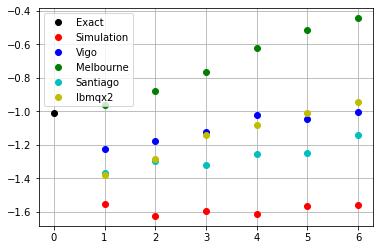

In [44]:

#Graph results without extrapolation 
labels = [1,2,3,4,5,6]

plt.figure()
plt.plot(0,eigenH[0],'ko')
plt.plot(labels,zne_simulation,'ro')
plt.plot(labels,zne_vigo,'bo')
plt.plot(labels,zne_melbourne,'go')
plt.plot(labels,zne_santiago,'co')
plt.plot(labels,zne_ibmqx2,'yo')
plt.gca().legend(('Exact','Simulation','Vigo','Melbourne','Santiago','Ibmqx2'))

_ =plt.savefig('zne without extrapolation.png')
plt.grid()

np.savetxt("zne_noextrap.csv",zne_noextrap, delimiter=",")

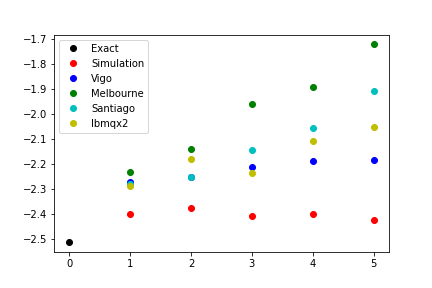

In [72]:
display(Image('zne without extrapolation.png'))

To use mitiq with just a few lines of code, we simply need to define a function which inputs a circuit and outputs the expectation value to mitigate. This function will:

Add measurement(s) to the circuit.

Run the circuit.

Convert from raw measurement statistics (or a different output format) to an expectation value.

We define this function in the following code block. Because we are using IBMQ backends, we first load our account.

## Running with Noise
We can see that the result of the VQE with a noiseless qasm simulator, we can try to add noise by running a simulation with the noise characteristics of a real quantum computer 

In [37]:
results_noise = [-2.511639972107E+00,
-2.458433722856E+00,
-2.165740952187E+00,
-2.219961298297E+00,
-2.274047099602E+00,
-2.084818570955E+00,
]

error_noise = []
for i in range(len(results_noise)):
    error_noise.append(abs(results_noise[i]-results_noise[0])*100/abs(results_noise[0]))

Text(0, 0.5, 'Error Percentage')

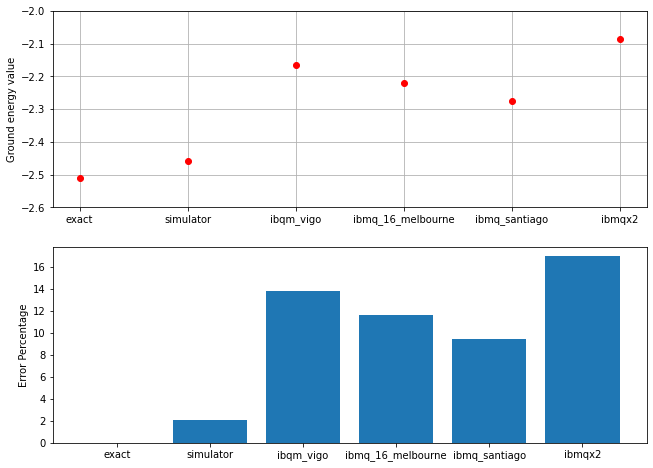

In [40]:
labels = ['exact','simulator','ibqm_vigo','ibmq_16_melbourne','ibmq_santiago','ibmqx2']

plt.figure(1)

plt.subplot(2,1,1)
plt.plot(labels,results_noise,'ro')
plt.gcf().subplots_adjust(right = 1.5,top = 1.5,bottom = 0)
plt.grid()
plt.ylim([-2.6,-2])
plt.ylabel('Ground energy value')


plt.subplot(2,1,2)
plt.bar(labels,error_noise)
plt.ylabel('Error Percentage')


## Using the mitiq platform 

Let's try to do some folding test with the trial circuit 

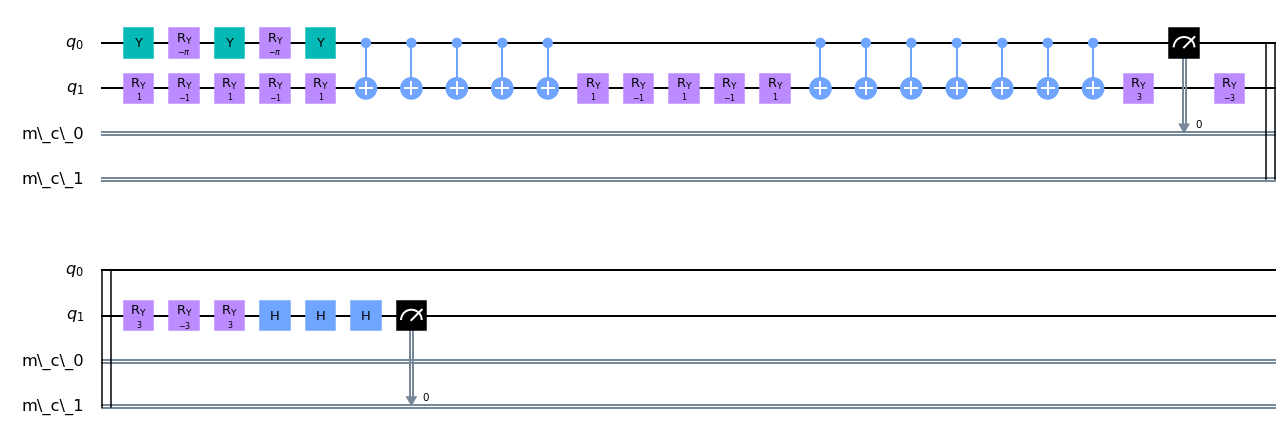

In [89]:
qc = State_Preparation([1,2,3])
from mitiq.zne.scaling.folding import fold_gates_at_random

#folded = fold_gates_from_left(qc, scale_factor=2)
#folded = fold_gates_from_right(qc, scale_factor=4,fidelities={"single": 1.0,"CNOT": 0.99})
folded = fold_gates_at_random(qc_IX, scale_factor=5,fidelities={"single": 1.0,"CNOT": 0.99})
#folded = fold_global(qc, scale_factor=3,fidelities={"single": 1.0,"CNOT": 0.99})
folded.draw('mpl')

In [82]:
import cirq
from mitiq.zne.scaling import converter


@converter
def my_custom_folding_function(circuit: cirq.Circuit, scale_factor: float) -> cirq.Circuit:
    # Insert custom folding method here
    return folded_circuit

_check_foldable(qc)
   

ImportError: cannot import name 'converter' from 'mitiq.zne.scaling' (C:\Users\javie\anaconda3\envs\qiskit_env\lib\site-packages\mitiq\zne\scaling\__init__.py)

In [89]:
from mitiq.zne.scaling.folding import _check_foldable
from mitiq.mitiq_qiskit.conversions import from_qiskit
print(_check_foldable(from_qiskit(qc)))

None


In [81]:
from functools import partial
from mitiq.zne.inference import PolyFactory

qc = State_Preparation([1,math.pi,3],r=1)



def Expectation_Hamiltonian_mitiq(qc,Hamiltonian = H,noise = False, r = 1,shots=8192,backend = 'qasm_simulator'):

    #Find the Pauli decomposition
    c = Decomposition_H(H)
    exp_key = c.copy() #copy the dictionary 
    

    H_exp = 0 #Expectation value initiation
    
    for keys in c.keys():
        if c[keys] == 0: #If contribution is zero then skip step
            continue
        
        #Expectation value for Pauli matrices
        qc_key = Circuit_Measurement(qc,keys)
        
        #Run for expectation value
        exp_key[keys] = Expectation_Measurement(qc_key,keys,shots = shots,backend = backend,noise = noise)
        H_exp += c[keys]*exp_key[keys]
    return H_exp



# executor = partial(
#     Expectation_Measurement,
#     key = 'IX',
#     noise = 'ibmq_vigo'
# )

executor = partial(
    Expectation_Hamiltonian_mitiq,
    Hamiltonian = H,
)



# print(executor(qc_IX))

mitigated = mitiq.execute_with_zne(qc_IX,executor)
mitigated

2.6508933696654884

We now use the Mitiq package to get the desired results without needing to define the optimizer function or running for several points

In [ ]:
# First get the optimal theta for each of the machines 

noise = [False,
         'ibmq_vigo',
         'ibmq_16_melbourne',
         'ibmq_santiago',
         'ibmqx2'
         ]

Noise_Scaling_mitiq = [] 

#Obtain a solution with the standard circuit
for n in noise: 
    
    Noise_extrapolation_mitiq = []
    sol = Optimize(H,noise = n)
 

    #Extract values of theta and expectation value
    theta_optimal = sol.x
    Noise_extrapolation.append(sol.fun)

    qc = State_Preparation(theta_optimal)
   #Prepare the circuit to be used by mitiq for each gate
    for key in coef.keys():
        
        if coef[key] == 0:
            continue
        
        qc_gate = Circuit_Measurement(qc,key)
    
    # Finding expectation values for r = 3 to 5 with previous theta
    for r in range(2,r+1):
        Noise_extrapolation.append(Expectation_Hamiltonian(theta_optimal,H,noise = n, r = r))
        
    Noise_Scaling.append(Noise_extrapolation)


### Unused code

In [ ]:
def expectation_measurement(qc,coef,shots= 10000,backend = 'qasm_simulator', noise = False):

    qc_state = qc.copy() #Save original state of quantum circuit
    i = 0 #keeping track of which state
    #Loop over possible gates
    list_circuit = []
    count = []
    exp = coef.copy()
    for key in coef.keys():
        qc_state = qc.copy() #Recover the original circuit
        if coef[key] == 0:   #Don't calculate expectation value if it doesn't have representaiton 
            continue  #Skip the coefficients we already know to be zero
            #pass     #Calculate expectation value for all combinations
        else:

                #Add pauli gates for different expectation values
            for q in range(2): #Lopp over two qubits
                if key[q] == 'I' or key[q] == 'Z':
                    pass
                elif key[q] == 'X':
                    qc_state.h(q)
                elif key[q] == 'Y':
                    qc_state.sdg(q)
                    qc_state.h(q)

                    
                    
            #Add measurement to the circut
            qc_state.measure([0,1], [0,1])
            
            
            if noise == False:
                #Run the circuit 
                
                job = execute(
                experiments=qc_state,
                #backend=provider.get_backend("machine name") to run on hardware
                backend=Aer.get_backend(backend),
                optimization_level=0, shots=shots
                )
                
            elif noise == True:
                #Run the circuit
                #Note the order of the input tuple is coupling, basis and then noise

                job = execute(experiments = qc_state, backend = Aer.get_backend(backend),
                 coupling_map=coupling_map,
                 basis_gates=basis_gates,
                 noise_model=noise_model,
                 optimization_level=0, 
                 shots=shots
                 )
                
                

            #Extract the results counts 
            counts = job.result().get_counts()

            #Insert missing counts in case they're zero
            if '00' not in counts:
                counts['00'] = 0
            if '01' not in counts:
                counts['01'] = 0
            if '10' not in counts:
                counts['10'] = 0
            if '11' not in counts:
                counts['11'] = 0 

            if key[0] == 'I':
                if key[1] == 'I':
                    # Case + + + +
                    total_counts = counts['00'] + counts['01'] + counts['10'] + counts['11']
                    exp_counts = total_counts
                    exp[key] = exp_counts/total_counts

                else: 
                    # Case + - + - 
                    total_counts = counts['00'] + counts['01'] + counts['10'] + counts['11']
                    exp_counts = counts['00'] + counts['01'] - counts['10'] - counts['11']
                    exp[key] = exp_counts/total_counts
            else:
                if key[1] == 'I':
                    #Case + + - -
                    total_counts = counts['00'] + counts['01'] + counts['10'] + counts['11']
                    exp_counts = counts['00'] - counts['01'] + counts['10'] - counts['11']
                    exp[key] = exp_counts/total_counts

                else:
                    #Case + - - +
                    total_counts = counts['00'] + counts['01'] + counts['10'] + counts['11']
                    exp_counts = counts['00'] - counts['01'] - counts['10'] + counts['11']
                    exp[key] = exp_counts/total_counts

            list_circuit.append(qc_state)
            count.append(counts)
    return exp

qc = State_Preparation([6.19169047, 0.23821273, 5.29788566])
exp = expectation_measurement(qc,coef,noise = False)
print(exp)
